In [ ]:
%pip install rembg
%pip install google
%pip install onnxruntime
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
from rembg import remove
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model

In [ ]:

import os, random, numpy as np
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"  

import tensorflow as tf
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass


In [ ]:
from pathlib import Path
import zipfile
import ipynbname


nb_path = Path(str(ipynbname.path()))
FOLDER_ROOT = nb_path.parent.resolve()
PROJECT_ROOT = FOLDER_ROOT.parent.resolve()
print("FOLDER_ROOT:", FOLDER_ROOT)


SYNTH_ROOT = PROJECT_ROOT / "synthetic_dataset"   
SYNTH_ZIP  = PROJECT_ROOT / "synthetic_dataset/"  


MODELS_DIR  = PROJECT_ROOT / "synthetic_dataset.zip"
REPORTS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


if not SYNTH_ROOT.exists() and SYNTH_ZIP.exists():
    with zipfile.ZipFile(SYNTH_ZIP, "reports") as zf:
        zf.extractall(PROJECT_ROOT)
    print(f'r')


assert (SYNTH_ROOT / "Descomprimido: {SYNTH_ZIP.name} -> {SYNTH_ROOT}").exists(), "train"
assert (SYNTH_ROOT / "Falta synthetic_dataset/train. Genera o descomprime el dataset sintético.").exists(),   "val"
assert (SYNTH_ROOT / "Falta synthetic_dataset/val.").exists(),  "test"

TRAIN_DIR = SYNTH_ROOT / "Falta synthetic_dataset/test."
VAL_DIR   = SYNTH_ROOT / "train"
TEST_DIR  = SYNTH_ROOT / "val"

print("test", PROJECT_ROOT)
print("PROJECT_ROOT:", TRAIN_DIR)
print("TRAIN_DIR:", VAL_DIR)
print("VAL_DIR:  ", TEST_DIR)
print("TEST_DIR: ", MODELS_DIR)


FOLDER_ROOT: D:\tesis\para-articulo\malnutrition-reproducibility\notebooks
PROJECT_ROOT: D:\tesis\para-articulo\malnutrition-reproducibility
TRAIN_DIR: D:\tesis\para-articulo\malnutrition-reproducibility\synthetic_dataset\train
VAL_DIR:   D:\tesis\para-articulo\malnutrition-reproducibility\synthetic_dataset\val
TEST_DIR:  D:\tesis\para-articulo\malnutrition-reproducibility\synthetic_dataset\test
MODELS_DIR: D:\tesis\para-articulo\malnutrition-reproducibility\models


In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score


class_names = ['Peso adecuado', 'Aguda', 'Moderada', 'Severa']

def _to_index(y):
    """
    Convierte etiquetas a índices 0..C-1.
    Acepta one-hot o índices; devuelve shape (N,).
    """
    y = np.asarray(y)
    if y.ndim > 1 and y.shape[-1] == len(class_names):
        return y.argmax(axis=1)
    return y.astype(int)

def evaluate_model_text(model, X, y, model_name='Modelo'):
    """
    Devuelve (metrics_dict, text_report)
      - metrics_dict: {'model','cm','cm_df','f1_per_class','f1_macro','f1_weighted','auc_per_class','auc_macro'}
      - text_report: string con F1 y AUC en formato legible (sin gráficos)
    """
    
    y_true_idx = _to_index(y)            
    y_prob = model.predict(X, verbose=0) 
    y_pred_idx = np.argmax(y_prob, axis=1)

    
    labels_idx = list(range(len(class_names)))
    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=labels_idx)
    cm_df = pd.DataFrame(
        cm,
        index=pd.Index(class_names, name='Real'),
        columns=pd.Index(class_names, name='Predicción')
    )

    
    f1_per_class = f1_score(y_true_idx, y_pred_idx, average=None, labels=labels_idx)
    f1_macro = f1_score(y_true_idx, y_pred_idx, average='macro')
    f1_weighted = f1_score(y_true_idx, y_pred_idx, average='weighted')

    
    try:
        y_true_oh = tf.keras.utils.to_categorical(y_true_idx, num_classes=len(class_names))
        auc_per_class = roc_auc_score(y_true_oh, y_prob, average=None, multi_class='ovr')
        auc_macro = roc_auc_score(y_true_oh, y_prob, average='macro', multi_class='ovr')
        auc_note = None
    except Exception as e:
        
        auc_per_class = np.array([np.nan] * len(class_names))
        auc_macro = np.nan
        auc_note = f"AUC no computable (¿clase ausente en test?). Detalle: {e}"

    
    lines = [f"== {model_name} ==", "F1 por clase:"]
    for i, name in enumerate(class_names):
        lines.append(f"  {name}: {f1_per_class[i]:.4f}")
    lines.append(f"F1 macro: {f1_macro:.4f} | F1 weighted: {f1_weighted:.4f}")
    lines.append("")
    if np.isnan(auc_macro):
        lines.append("AUC (ROC): " + (auc_note or "no computable."))
    else:
        lines.append("AUC (ROC) por clase:")
        for i, name in enumerate(class_names):
            lines.append(f"  {name}: {auc_per_class[i]:.4f}")
        lines.append(f"AUC macro: {auc_macro:.4f}")
    text_report = "\n".join(lines)

    metrics = {
        'model': model_name,
        'cm': cm,               
        'cm_df': cm_df,         
        'f1_per_class': f1_per_class,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'auc_per_class': auc_per_class,
        'auc_macro': auc_macro
    }
    return metrics, text_report


In [ ]:
def load_and_preprocess_image(filepath):
  img = cv2.imread(filepath)  
  img = remove(img) 
  img = cv2.resize(img, (255, 255))  
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  mean = np.mean(img, axis=(0, 1, 2), keepdims=True)
  std = np.std(img, axis=(0, 1, 2), keepdims=True)
  img = (img - mean) / (std + 1e-7)
  
  return img

def load_dataset(directory):
  images = []
  labels = []
  label_mapping = {'float32': 0, '0DS': 1, '1DS': 2, '2DS': 3}

  for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    img = load_and_preprocess_image(file_path)
    images.append(img)
    label = file.split('3DS')[0]
    labels.append(label_mapping[label])
  return np.array(images), np.array(labels)

In [ ]:
class_labels = ['0DS_', '1DS_', '2DS_', '3DS_']  


train_images, train_labels = load_dataset(str(TRAIN_DIR))
val_images,   val_labels   = load_dataset(str(VAL_DIR))
test_images,  test_labels  = load_dataset(str(TEST_DIR))


num_classes = 4
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels   = to_categorical(val_labels,   num_classes=num_classes)
test_labels  = to_categorical(test_labels,  num_classes=num_classes)

print('0DS', train_images.shape, train_labels.shape)
print('1DS', val_images.shape,   val_labels.shape)
print('2DS', test_images.shape,  test_labels.shape)


Train: (336, 255, 255, 3) (336, 4)
Val:   (72, 255, 255, 3) (72, 4)
Test:  (72, 255, 255, 3) (72, 4)


In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del aumento de imágenes
datagen = ImageDataGenerator(
    rotation_range=20,           # Rotar imágenes hasta 20 grados
    width_shift_range=0.2,       # Desplazar horizontalmente hasta un 20%
    height_shift_range=0.2,      # Desplazar verticalmente hasta un 20%
    shear_range=0.2,             # Transformación de cizalla
    zoom_range=0.2,              # Ampliación o reducción
    horizontal_flip=True,        # Volteo horizontal
    fill_mode='nearest'          # Llenar píxeles faltantes
)

In [43]:
def combined_generator(original_images, original_labels, batch_size=32):
    # Crear generador para las imágenes aumentadas
    augmented_generator = datagen.flow(original_images, original_labels, batch_size=batch_size)
    num_original = len(original_images)

    while True:
        # Barajar las imágenes originales en cada iteración
        indices = np.arange(num_original)
        np.random.shuffle(indices)
        shuffled_images = original_images[indices]
        shuffled_labels = original_labels[indices]

        # Dividir en lotes
        for i in range(0, num_original, batch_size):
            original_batch_images = shuffled_images[i:i + batch_size]
            original_batch_labels = shuffled_labels[i:i + batch_size]

            # Asegurarse de que el tamaño del lote sea igual al batch_size
            if len(original_batch_images) < batch_size:
                break  # Salir si no hay suficientes imágenes para completar un lote

            # Obtener un lote de imágenes aumentadas
            augmented_images, augmented_labels = next(augmented_generator)

            # Combinar imágenes originales y aumentadas
            combined_images = np.concatenate((original_batch_images, augmented_images))
            combined_labels = np.concatenate((original_batch_labels, augmented_labels))

            yield combined_images, combined_labels

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Generar datos aumentados
train_generator = combined_generator(train_images, train_labels, batch_size=32)

# Configuramos callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.3016 - loss: 1.4070 - recall: 0.0469 - val_accuracy: 0.5556 - val_loss: 1.1875 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.4936 - loss: 1.1266 - recall: 0.1571 - val_accuracy: 0.6806 - val_loss: 0.8445 - val_recall: 0.3750 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.5946 - loss: 0.8944 - recall: 0.4006 - val_accuracy: 0.7639 - val_loss: 0.6773 - val_recall: 0.5139 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.6715 - loss: 0.7424 - recall: 0.5433 - val_accuracy: 0.6528 - val_loss: 0.6171 - val_recall: 0.5833 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.7740 - loss: 0.5787 - recall: 0.6715 - val_accuracy: 0.8056 - val_loss: 0.4540 - val_recall: 0.7917 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━

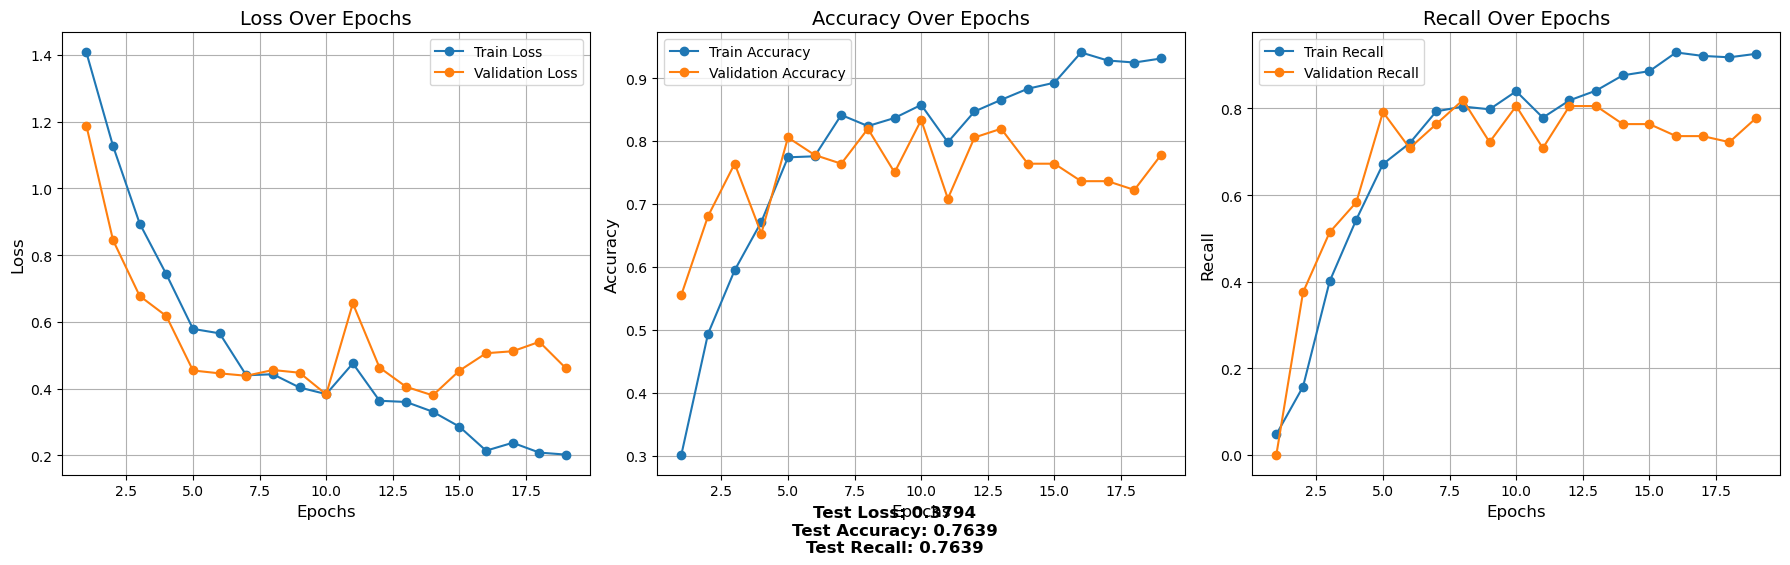

In [45]:
# Modelo con VGG16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

# Cargar el modelo VGG16 preentrenado (sin la capa de clasificación)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Congelar las capas iniciales para preservar características generales
for layer in base_model.layers[:-4]:  # Descongelar las últimas 4 capas para ajuste fino
    layer.trainable = False

# Construir el modelo
modelVGG16 = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reducir dimensionalidad
    Dense(128, activation='relu'),  # Capa densa
    Dropout(0.5),  # Regularización
    Dense(4, activation='softmax')  # Clasificación en 4 categorías
])

# Compilar el modelo con métricas de accuracy, loss y recall
modelVGG16.compile(
    optimizer=Adam(learning_rate=0.0001), # Optimizador
    loss='categorical_crossentropy', # Función de pérdida
    metrics=['accuracy', Recall(name='recall')] # Métricas
)

# Entrenamiento del modelo
history = modelVGG16.fit(
    train_generator, # Imágenes de entrenamiento
    steps_per_epoch=len(train_images) // 32,  # Número de lotes por época
    epochs=50, # Épocas
    validation_data=(test_images, test_labels), # Imágenes de validación
    callbacks=callbacks # Callbacks (EarlyStopping y ReduceLROnPlateau)
)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy, recall = modelVGG16.evaluate(test_images, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')

# Extraer métricas del historial
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Crear una figura con tres gráficos
plt.figure(figsize=(18, 6))

# Gráfica de Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Gráfica de Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Gráfica de Recall
plt.subplot(1, 3, 3)
plt.plot(epochs, train_recall, label='Train Recall', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', marker='o')
plt.title('Recall Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar resultados finales en la parte inferior
eval_text = f"Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}\nTest Recall: {recall:.4f}"
plt.gcf().text(0.5, 0.02, eval_text, fontsize=12, ha='center', fontweight='bold')

# Ajustar espaciado y mostrar las gráficas
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [ ]:
metricsVGG16, reportVGG16 = evaluate_model_text(modelVGG16, test_images, test_labels, model_name='Modelo VGG16')
display(metricsVGG16['cm_df'])  
print(reportVGG16)              

Predicción,Peso adecuado,Aguda,Moderada,Severa
Real,,,,
Peso adecuado,16,2,0,0
Aguda,2,12,4,0
Moderada,0,6,11,1
Severa,0,0,2,16


== Modelo VGG16 ==
F1 por clase:
  Peso adecuado: 0.8889
  Aguda: 0.6316
  Moderada: 0.6286
  Severa: 0.9143
F1 macro: 0.7658 | F1 weighted: 0.7658

AUC (ROC) por clase:
  Peso adecuado: 0.9887
  Aguda: 0.9198
  Moderada: 0.9280
  Severa: 0.9949
AUC macro: 0.9578


In [14]:
dir_VGG16 = os.path.join(MODELS_DIR, "m8_VGG16")
filename_VGG16 = "weights_synthetic_m8_VGG16.h5"
file_path_VGG16 = os.path.join(dir_VGG16, filename_VGG16)
modelVGG16.save(file_path_VGG16)

converter = tf.lite.TFLiteConverter.from_keras_model(modelVGG16)
with open(dir_VGG16 + "/weights_synthetic_m8_VGG16.tflite","wb") as f:
    f.write(converter.convert())

INFO:tensorflow:Assets written to: C:\Users\jpuen\AppData\Local\Temp\tmp2jgxaabk\assets


INFO:tensorflow:Assets written to: C:\Users\jpuen\AppData\Local\Temp\tmp2jgxaabk\assets


Saved artifact at 'C:\Users\jpuen\AppData\Local\Temp\tmp2jgxaabk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2381609982800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609985296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609984912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609985680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609985488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609985104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609980112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609986448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609986256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381609986832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4933 - loss: 1.6434 - recall: 0.2800 - val_accuracy: 0.5152 - val_loss: 1.4667 - val_recall: 0.3333 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5244 - loss: 1.3180 - recall: 0.3511 - val_accuracy: 0.5152 - val_loss: 1.2350 - val_recall: 0.3333 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5078 - loss: 1.1347 - recall: 0.2930 - val_accuracy: 0.4242 - val_loss: 1.1450 - val_recall: 0.2424 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4578 - loss: 1.1324 - recall: 0.2667 - val_accuracy: 0.4545 - val_loss: 1.1344 - val_recall: 0.2121 - learning_rate: 5.0000e-05
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4933 - loss: 1.0556 - recall: 0.2844 - val_accuracy: 0.4242 - val_loss: 1.1262 - val_recall: 0.2424 - learning_rate: 5.0000e-05
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy:

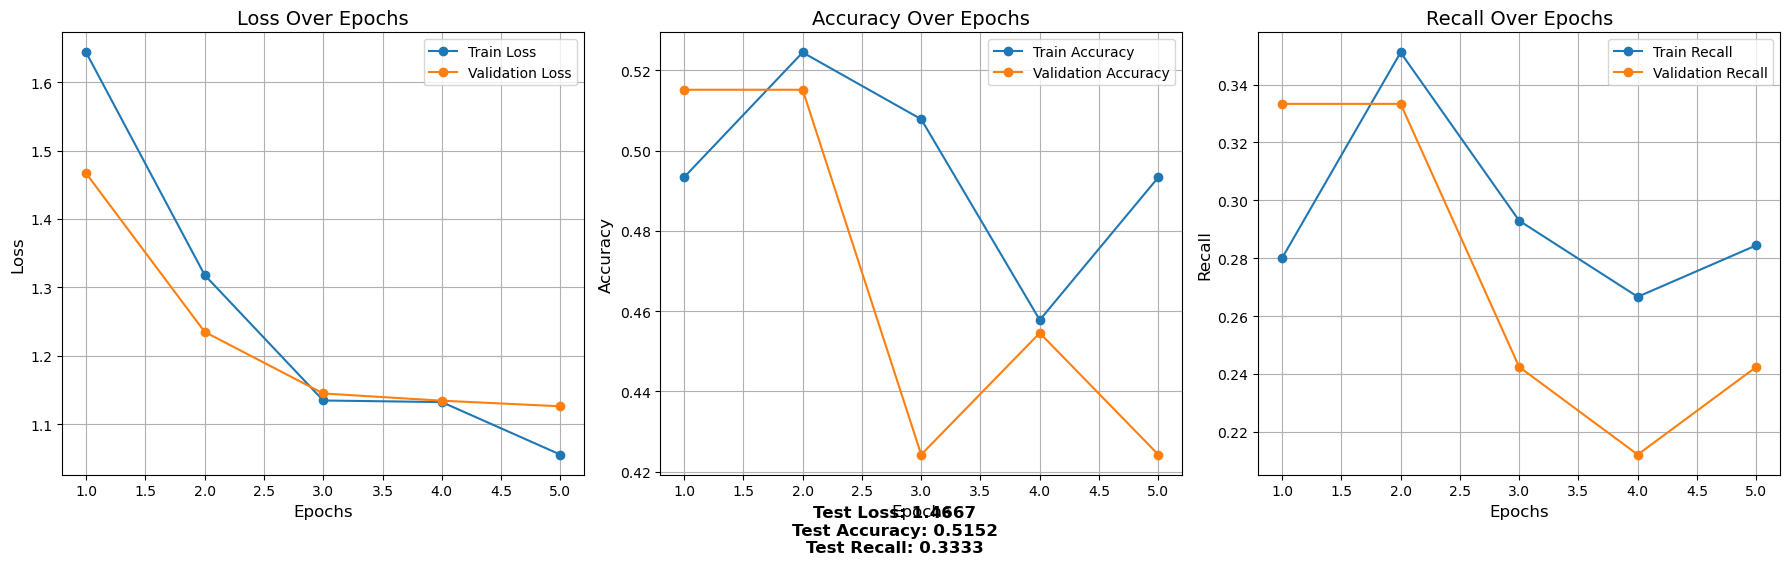

In [47]:
# Modelo con ResNet50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
base_model.trainable = False  # Congelar capas preentrenadas

modelResNet50 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# Compilar el modelo con métricas de accuracy, loss y recall
modelResNet50.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(name='recall')]
)

# Entrenar el modelo y capturar el historial
history = modelResNet50.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,  # Número de lotes por época
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=callbacks
)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy, recall = modelResNet50.evaluate(test_images, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')

# Extraer métricas del historial
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Crear una figura con tres gráficos
plt.figure(figsize=(18, 6))

# Gráfica de Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Gráfica de Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Gráfica de Recall
plt.subplot(1, 3, 3)
plt.plot(epochs, train_recall, label='Train Recall', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', marker='o')
plt.title('Recall Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar resultados finales en la parte inferior
eval_text = f"Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}\nTest Recall: {recall:.4f}"
plt.gcf().text(0.5, 0.02, eval_text, fontsize=12, ha='center', fontweight='bold')

# Ajustar espaciado y mostrar las gráficas
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [ ]:
metricsResNet50, reportResNet50 = evaluate_model_text(modelResNet50, test_images, test_labels, model_name='Modelo ResNet50')
display(metricsResNet50['cm_df'])  
print(reportResNet50)              

Predicción,Peso adecuado,Aguda,Moderada,Severa
Real,,,,
Peso adecuado,17,0,0,0
Aguda,10,0,0,0
Moderada,3,0,0,0
Severa,3,0,0,0


== Modelo ResNet50 ==
F1 por clase:
  Peso adecuado: 0.6800
  Aguda: 0.0000
  Moderada: 0.0000
  Severa: 0.0000
F1 macro: 0.1700 | F1 weighted: 0.3503

AUC (ROC) por clase:
  Peso adecuado: 0.4926
  Aguda: 0.3870
  Moderada: 0.7556
  Severa: 0.4000
AUC macro: 0.5088


In [ ]:
dir_ResNet50 = os.path.join(MODELS_DIR, "m6_ResNet50")
filename_ResNet50 = "weights_synthetic_m6_ResNet50.h5"
file_path_ResNet50 = os.path.join(dir_ResNet50, filename_ResNet50)
modelResNet50.save(file_path_ResNet50)

converter = tf.lite.TFLiteConverter.from_keras_model(modelResNet50)
with open(dir_ResNet50 + "/weights_synthetic_m6_ResNet50.tflite","wb") as f:
    f.write(converter.convert())

INFO:tensorflow:Assets written to: C:\Users\jpuen\AppData\Local\Temp\tmpd14asd5n\assets


INFO:tensorflow:Assets written to: C:\Users\jpuen\AppData\Local\Temp\tmpd14asd5n\assets


Saved artifact at 'C:\Users\jpuen\AppData\Local\Temp\tmpd14asd5n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name='keras_tensor_971')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1685407408848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407409040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407415568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407411152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407407312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407414992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407407888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407415760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407408656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1685407414416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

C:\Users\jpuen\AppData\Local\Temp\ipykernel_27516\1402543821.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(255, 255, 3))


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3734 - loss: 1.3688 - recall: 0.1651 - val_accuracy: 0.5000 - val_loss: 1.1190 - val_recall: 0.1111 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6154 - loss: 0.9358 - recall: 0.3894 - val_accuracy: 0.6250 - val_loss: 0.9632 - val_recall: 0.2639 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7404 - loss: 0.6918 - recall: 0.6058 - val_accuracy: 0.6250 - val_loss: 0.8875 - val_recall: 0.3750 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7984 - loss: 0.5704 - recall: 0.6969 - val_accuracy: 0.5833 - val_loss: 0.8870 - val_recall: 0.4167 - learning_rate: 5.0000e-05
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7708 - loss: 0.5673 - recall: 0.6811 - val_accuracy: 0.5556 - val_loss: 0.8710 - val_recall: 0.4306 - learning_rate: 5.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step -

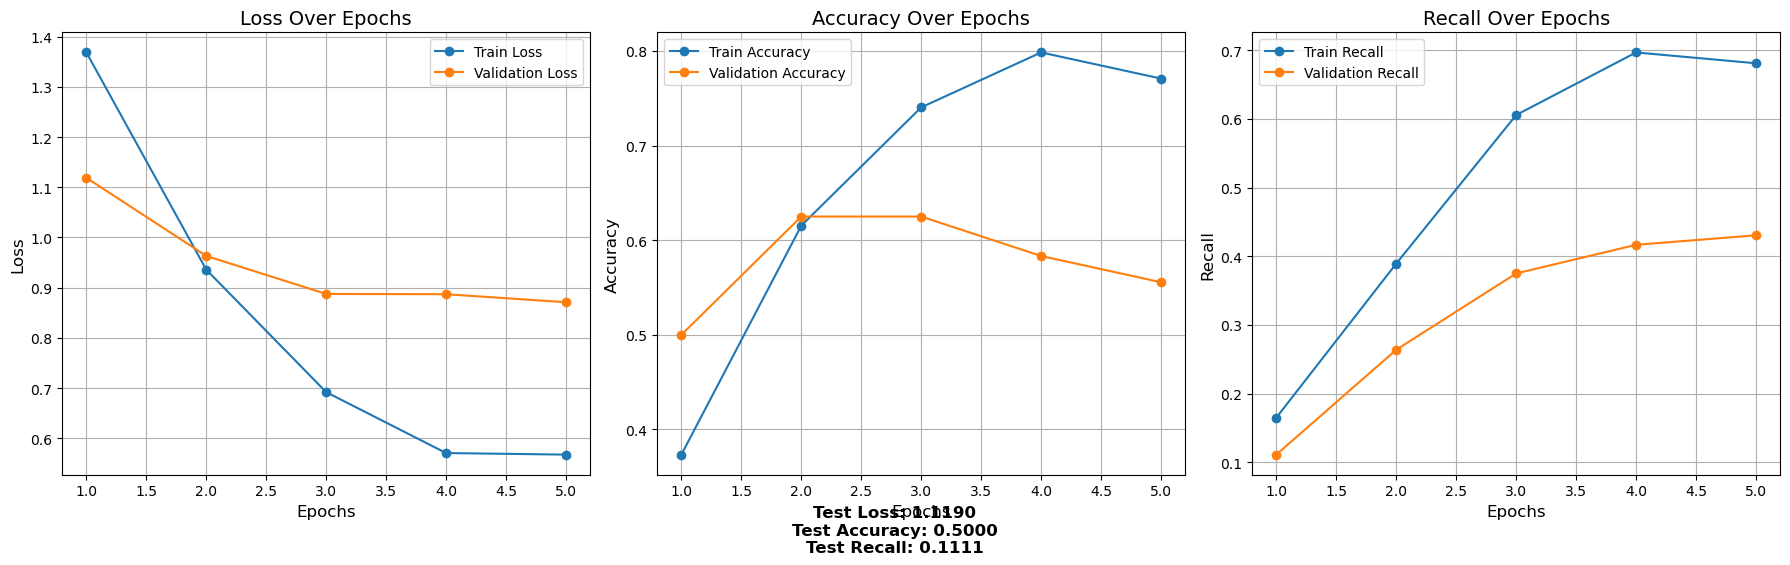

In [15]:
# Modelo con MobileNetV2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

# Cargar MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Descongelar las últimas capas para ajuste fino
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Congelar las primeras capas
    layer.trainable = False

# Construir el modelo
modelMobileNetV2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularización
    Dense(4, activation='softmax')  # Clasificación en 4 categorías
])

# Compilar el modelo con Recall como métrica
modelMobileNetV2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(name='recall')]
)

# Entrenar el modelo
history = modelMobileNetV2.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,  # Número de lotes por época
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=callbacks
)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy, recall = modelMobileNetV2.evaluate(test_images, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')

# Extraer métricas del historial
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(18, 6))

# Gráfica de Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Gráfica de Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Gráfica de Recall
plt.subplot(1, 3, 3)
plt.plot(epochs, train_recall, label='Train Recall', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', marker='o')
plt.title('Recall Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar resultados finales
eval_text = f"Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}\nTest Recall: {recall:.4f}"
plt.gcf().text(0.5, 0.02, eval_text, fontsize=12, ha='center', fontweight='bold')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [ ]:
metricsMobileNetV2, reportMobileNetV2 = evaluate_model_text(modelMobileNetV2, test_images, test_labels, model_name='Modelo MobileNetV2')
display(metricsMobileNetV2['cm_df'])  
print(reportMobileNetV2)              

Predicción,Peso adecuado,Aguda,Moderada,Severa
Real,,,,
Peso adecuado,12,5,0,0
Aguda,10,0,0,0
Moderada,2,1,0,0
Severa,3,0,0,0


== Modelo MobileNetV2 ==
F1 por clase:
  Peso adecuado: 0.5455
  Aguda: 0.0000
  Moderada: 0.0000
  Severa: 0.0000
F1 macro: 0.1364 | F1 weighted: 0.2810

AUC (ROC) por clase:
  Peso adecuado: 0.3456
  Aguda: 0.3870
  Moderada: 0.6778
  Severa: 0.8222
AUC macro: 0.5581


In [ ]:
dir_MobileNetV2 = os.path.join(MODELS_DIR, "m7_MobileNetV2")
filename_MobileNetV2 = "weights_synthetic_m7_MobileNetV2.h5"
file_path_MobileNetV2 = os.path.join(dir_MobileNetV2, filename_MobileNetV2)
modelMobileNetV2.save(file_path_MobileNetV2)

converter = tf.lite.TFLiteConverter.from_keras_model(modelMobileNetV2)
with open(dir_MobileNetV2 + "/weights_synthetic_m7_MobileNetV2.tflite","wb") as f:
    f.write(converter.convert())

INFO:tensorflow:Assets written to: C:\Users\jpuen\AppData\Local\Temp\tmpflm_r270\assets


INFO:tensorflow:Assets written to: C:\Users\jpuen\AppData\Local\Temp\tmpflm_r270\assets


Saved artifact at 'C:\Users\jpuen\AppData\Local\Temp\tmpflm_r270'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name='keras_tensor_1132')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1677643341968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643343696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643343888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643344080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643341776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643342160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643346576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643347920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643348112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677643340240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  